In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from skspatial.objects import LineSegment, Line, Vector

# some helper functions
from helpers import (
    get_arc_point,
    draw_arc,
    rotate,
    translate,
    flip_y,
    flip_x,
    optimize_points,
    chaikin,
    rotate_point,
    scale,
)
from pcb_json import (
    dump_json,
    plot_json,
    create_via,
    create_pad,
    create_pin,
    create_silk,
    create_mounting_hole,
)

from enum import Enum

Layer = Enum("Layer", "FRONT BACK")

In [2]:
# Track width and spacing (mm)
TRACK_WIDTH = 0.2
TRACK_SPACING = 0.17

INNER_DIAMETER = 2

COPPER_THICKNESS = 1 * 0.0348 # oz/sqr_foot * mm/(oz/sqr_foot) >>>> convert to mm

VOLTAGE = 3.7

# via defaults (mm)
VIA_DIAM = 0.8
VIA_DRILL = 0.4

# this is for the PCB connector - see https://www.farnell.com/datasheets/2003059.pdf
PAD_ENABLE = False
PAD_WIDTH = 3
PAD_HEIGHT = 2
PAD_PITCH = 2.5

# Vias for connecting to the coils
COIL_INPUT_VIAS_ENABLE = True

# PCB edge cuts
PCB_EDGE_CUTS = True

# Coil net name
COIL_NET_NAME = "coils"

# this is for a 1.27mm pitch pin
PIN_DIAM = 1.0
PIN_DRILL = 0.65

In [3]:
# Coil params
#TURNS = 12

MAX_DIAMETER = 28 # mm
max_radius = ((MAX_DIAMETER - INNER_DIAMETER) / 2) - TRACK_SPACING

TURNS = (max_radius) / (TRACK_WIDTH + TRACK_SPACING)
TURNS = int(TURNS)


COIL_CENTER_RADIUS = 16
COIL_VIA_RADIUS = 17

# Coil input vias
COIL_INPUT_VIA_RADIUS = 22


USE_SPIRAL = False

if USE_SPIRAL:
    COIL_VIA_RADIUS = 20.5
    COIL_CENTER_RADIUS = 20.5

LAYERS = 2

# Arbitrary Coil Generation

In [4]:
# templates must be simetric around the X axis and must include the center points on both size (e.g. (X1, 0).... (X2, 0) )
# template must also be convex
triangle = [
    (-3.5, 0),
    (-3.5, -0.01),
    (1.9, -1.45),
    (1.9, 0.0),
    (1.9, 1.45),
    (-3.5, 0.01),
]

hexagon = [
    (-1, 0),
    (-0.5, -0.86603),
    (0.5, -0.86603),
    (1, 0),
    (0.5, 0.86603),
    (-0.5, 0.86603),
]

hexagon_cw = [
    (-1, 0),
    (-0.5, 0.86603),
    (0.5, 0.86603),
    (1, 0),
    (0.5, -0.86603),
    (-0.5, -0.86603),
]

vert_hexagon = [
    (-0.86603, 0),
    (-0.86603, -0.5),
    (0, -1),
    (0.86603, -0.5),
    (0.86603, 0),
    (0.86603, 0.5),
    (0, 1),
    (-0.86603, 0.5),
]


template = np.multiply(hexagon, INNER_DIAMETER / 2)

(-2.1, 0.1, -0.952633, 0.952633)

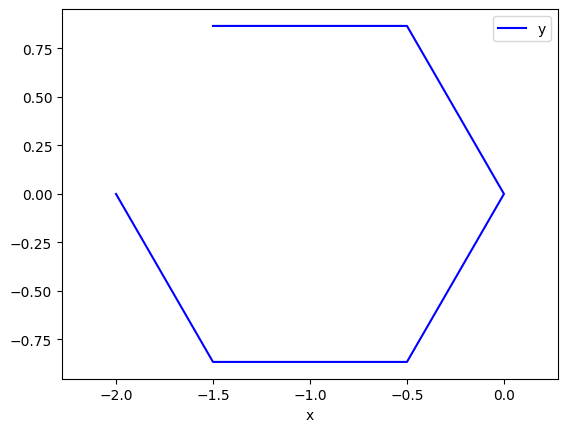

In [5]:
# plot the template shape wrapping around to the first point
df = pd.DataFrame(template + [template[0]], columns=["x", "y"])
ax = df.plot.line(x="x", y="y", color="blue")
ax.axis("equal")

In [6]:
def calculate_point(point, point1, point2, spacing, turn):
    reference_vector = Vector([-100, 0])
    angle = np.rad2deg(Vector(point).angle_between(reference_vector))
    if point[1] > 0:
        angle = 360 - angle
    vector = Vector(point1) - Vector(point2)
    normal = vector / np.linalg.norm(vector)
    # rotate the vector 90 degrees
    normal = np.array([-normal[1], normal[0]])
    # move the  point along the normal vector by the spacing
    offset = spacing * (turn * 360 + angle) / 360
    coil_point = point + normal * offset
    return (coil_point[0], coil_point[1])


def get_points(template, turns, spacing):
    coil_points = [(0,0)]
    reference_vector = Vector([-100, 0])
    template_index = 0
    template_length = len(template)
    for turn in range(turns * template_length):
        point1 = template[template_index % template_length]
        point2 = template[(template_index + 1) % template_length]

        # calculate the new positions of the points
        coil_point1 = calculate_point(
            point1, point1, point2, spacing, template_index // template_length
        )
        coil_point2 = calculate_point(
            point2, point1, point2, spacing, (template_index + 1) // template_length
        )
        # adjust the previous point so that the previous line intersects with this new line
        # this prevents any cutting of corners
        if len(coil_points) >= 2:
            # create a line from the previous two points
            line1 = Line(
                coil_points[len(coil_points) - 2],
                np.array(coil_points[len(coil_points) - 1])
                - np.array(coil_points[len(coil_points) - 2]),
            )
            # create a line from the two new points
            line2 = Line(
                np.array(coil_point1),
                np.array(np.array(coil_point1) - np.array(coil_point2)),
            )
            # find the intersection of the two lines
            try:
                intersection = line1.intersect_line(line2)
                # replace the previous point with the intersection
                coil_points[len(coil_points) - 1] = intersection
                # add the new point
                coil_points.append(coil_point2)
            except:
                # the lines did not intersect so just add the points
                coil_points.append(coil_point1)
                coil_points.append(coil_point2)
        else:
            coil_points.append(coil_point1)
            coil_points.append(coil_point2)

        template_index = template_index + 1
    return coil_points

In [7]:
def get_spiral(turns, start_radius, thickness, layer=Layer.FRONT):
    points = [(0,0)]
    # create a starting point in the center
    for angle in np.arange(0, turns * 360, 1):
        radius = start_radius + thickness * angle / 360
        if layer == Layer.BACK:
            x = radius * np.cos(np.deg2rad(angle + 180))
            y = radius * np.sin(np.deg2rad(angle + 180))
            points.append((x, -y))
        else:
            x = radius * np.cos(np.deg2rad(angle))
            y = radius * np.sin(np.deg2rad(angle))
            points.append((x, y))
    return points

In [8]:
if not USE_SPIRAL:
    print("Not using spiral")
    template_b = []
    for i in range(len(template)):
        template_b.append(template[len(template) - i - len(template) // 2])
    template_b = flip_x(template_b)
    points_b = chaikin(
        optimize_points(
            flip_x(get_points(template_b, TURNS, TRACK_SPACING + TRACK_WIDTH))
        ),
        2,
    )
    points_f = chaikin(
        optimize_points(get_points(template, TURNS, TRACK_SPACING + TRACK_WIDTH)), 2
    )
else:
    print("Using spiral")
    points_f = get_spiral(
        TURNS, VIA_DIAM / 2 + TRACK_SPACING, TRACK_SPACING + TRACK_WIDTH, Layer.FRONT
    )
    points_b = get_spiral(
        TURNS, VIA_DIAM / 2 + TRACK_SPACING, TRACK_SPACING + TRACK_WIDTH, Layer.BACK
    )

    points_f = [(0, 0)] + points_f
    points_b = [(0, 0)] + points_b
    print("Track points", len(points_f), len(points_b))

Not using spiral
Optimised from 206 to 206 points
Optimised from 206 to 206 points


Track points 821 821
first point: [-0.095, 0.0]   last point: (-11.89461403461987, 6.289974963118986)
Able to fit 34 turns
total height: 27.231156465626555 
total width: 29.61773705346775


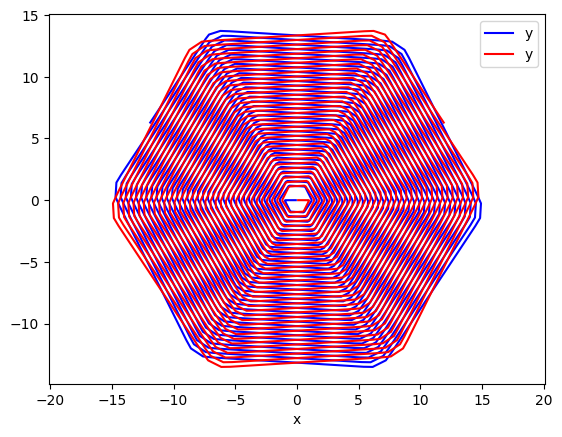

In [9]:
df = pd.DataFrame(points_f, columns=["x", "y"])
ax = df.plot.line(x="x", y="y", color="blue")
ax.axis("equal")
df = pd.DataFrame(points_b, columns=["x", "y"])
ax = df.plot.line(x="x", y="y", color="red", ax=ax)

print("Track points", len(points_f), len(points_b))

print("first point:", points_f[0], "  last point:", points_f[-1])

print("Able to fit", TURNS, "turns")
#print("\nTest", np.min(points_b, axis=0)[0])
numpy_points_f = np.array(points_f)
min_x = min(numpy_points_f[:, 0])
max_x = max(numpy_points_f[:, 0])
min_y = min(numpy_points_f[:, 1])
max_y = max(numpy_points_f[:, 1])

print("total height:", max_y - min_y, "\ntotal width:", max_x - min_x)

# Generate PCB Layout

In [10]:
# calculate the total length of the track to compute the resistance
total_length_front = 0
for i in range(len(points_f) - 1):
    total_length_front += np.linalg.norm(
        np.array(points_f[i + 1]) - np.array(points_f[i])
    )
print("Total length front", total_length_front)

total_length_back = 0
for i in range(len(points_b) - 1):
    total_length_back += np.linalg.norm(
        np.array(points_b[i + 1]) - np.array(points_b[i])
    )
print("Total length back", total_length_back)


estimated_resistance = (total_length_front + total_length_back) / (TRACK_WIDTH * COPPER_THICKNESS)
estimated_resistance *= 17.4e-6 ## copper resistivity (near ambient temperature)
print("Estimated resistance:", estimated_resistance, "ohms")

Total length front 1652.6962808223793
Total length back 1652.6962808223793
Estimated resistance: 8.263481404111896 ohms


In [11]:
vias = []
tracks_f = []
tracks_b = []
pads = []
pins = []
mounting_holes = []
silk = []
components = []
edge_cuts = []



tracks_f.append({"net": COIL_NET_NAME, "pts": points_f})
tracks_b.append({"net": COIL_NET_NAME, "pts": points_b})
## put a via at the first point of the front coil
vias.append(create_via(points_f[0], COIL_NET_NAME))


# Multi-Layer

In [12]:
# if we are doing multiple layers then duplicate the front and back layers
tracks_in = []
if LAYERS >= 4:
    tracks_in.append(tracks_b.copy())
    tracks_in.append(tracks_f.copy())
if LAYERS >= 6:
    tracks_in.append(tracks_b.copy())
    tracks_in.append(tracks_f.copy())
if LAYERS == 8:
    tracks_in.append(tracks_b.copy())
    tracks_in.append(tracks_f.copy())

# Generate JSON

In [13]:
filename = "Hex_coil_" + str(TRACK_WIDTH) + "mm_trace_" + str(TURNS) + "_turns_" + '{0:.2f}'.format(VOLTAGE / estimated_resistance * TURNS) + "_score_.json"

# dump out the json version
json_result = dump_json(
    filename=filename,
    track_width=TRACK_WIDTH,
    pin_diam=PIN_DIAM,
    pin_drill=PIN_DRILL,
    via_diam=VIA_DIAM,
    via_drill=VIA_DRILL,
    vias=vias,
    pins=pins,
    pads=pads,
    silk=silk,
    tracks_f=tracks_f,
    tracks_in=tracks_in,
    tracks_b=tracks_b,
    mounting_holes=mounting_holes,
    edge_cuts=edge_cuts,
    components=components,
)

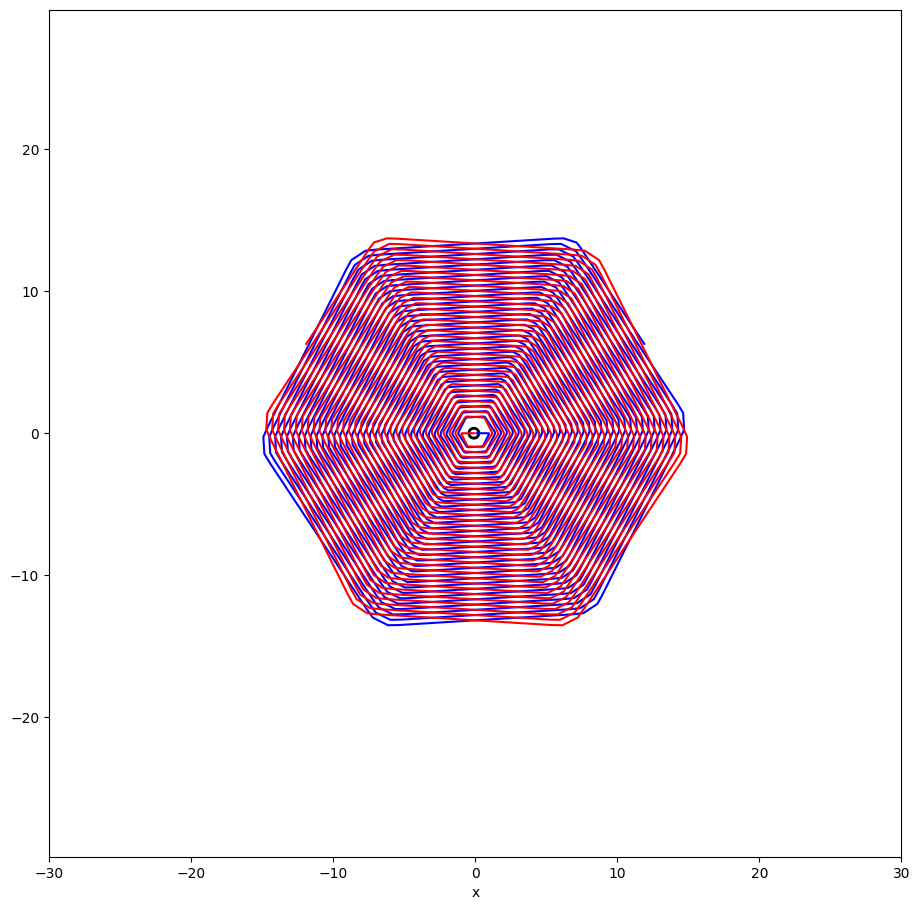

In [14]:
# plot the json
plot_json(json_result)

In [15]:
print("\n:::: Final Results: ::::\n")
print("Track Width:", TRACK_WIDTH)
print("Track Spacing:", TRACK_SPACING)
print("Turns:", TURNS)
print("Coil Dimensions:", max_y - min_y, "mm  x ", max_x - min_x, "mm")
print("Estimated Resistance:", estimated_resistance, "ohms")

print("\nWith", VOLTAGE, "Volts, the maximum current will be:", VOLTAGE / estimated_resistance, "Amps")

print("The magnetic coefficient estimate (I * TURNS) is:", '{0:.2f}'.format(VOLTAGE / estimated_resistance * TURNS))


:::: Final Results: ::::

Track Width: 0.2
Track Spacing: 0.17
Turns: 34
Coil Dimensions: 27.231156465626555 mm  x  29.61773705346775 mm
Estimated Resistance: 8.263481404111896 ohms

With 3.7 Volts, the maximum current will be: 0.44775317073490184 Amps
The magnetic coefficient estimate (I * TURNS) is: 15.22
